In [1]:
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install opencv-contrib-python
!pip install tensorflow-addons
import os
import cv2
import time
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Lambda, Concatenate
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
from tensorflow.keras.layers import (
    Input, SeparableConv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Conv2DTranspose,
    Concatenate, SpatialDropout2D, ReLU, GlobalAveragePooling2D, Add,
    GlobalMaxPooling2D, Dense, Reshape, Multiply, Add, Conv2D, Lambda, Activation
)
from tensorflow.keras.activations import swish
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.layers import Conv2D, Activation, Add, Multiply, UpSampling2D, Concatenate
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    UpSampling2D, Concatenate, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-2ju50imy
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-2ju50imy
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp311-cp311-linux_x86_64.whl size=3440332 sha256=bc9b8fbefc2a432488978c88f243bc5ac93c85333e96eae55036e655b035760f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ox1w79pb/wheels/ce/8e/34/6dcfa200a9e2ae3627d8009b8bd1ca9b24512bec50a93304de
Successfully built pydensecrf
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Suc

2025-07-01 03:15:03.317929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751339703.508732      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751339703.565840      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
working_dir = '/kaggle/working'

# Duyệt qua toàn bộ file/thư mục trong /kaggle/working
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Xóa file hoặc symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Xóa thư mục
            print(f"❌ xóa thành công {item_path}")
    except Exception as e:
        print(f"Lỗi khi xóa {item_path}: {e}")


❌ xóa thành công /kaggle/working/.virtual_documents


In [3]:
def load_isic_dataset(image_path, mask_path, binary_path, csv_file, img_size=(256, 256)):
    """
    Đọc và xử lý dữ liệu từ ISIC 2017 dataset

    Args:
        image_path: Đường dẫn đến thư mục chứa ảnh gốc
        mask_path: Đường dẫn đến thư mục chứa mask
        binary_path: Đường dẫn đến thư mục chứa mask nhị phân
        csv_file: Đường dẫn đầy đủ đến file CSV chứa nhãn
        label_name: Tên cột chứa nhãn trong file CSV
        img_size: Kích thước ảnh đầu ra (width, height)

    Returns:
        images: Numpy array chứa các ảnh đã xử lý
        masks: Numpy array chứa các mask đã xử lý
        binary_masks: Dict chứa mask nhị phân của từng ảnh đã xử lý
        image_ids: List các ID của ảnh
        labels: List các nhãn tương ứng với ảnh
    """

    # Lấy danh sách các file ảnh
    image_files = sorted(glob(os.path.join(image_path, "ISIC_*.jpg")))

    # Khởi tạo lists để lưu dữ liệu
    images = []
    masks = []
    binary_masks = {}
    image_ids = []
    labels = []

    # Đọc file CSV
    csv_data = pd.read_csv(csv_file)
    mel_label = csv_data['melanoma'].astype("int64")

    print("Đang đọc và xử lý dữ liệu...")
    for index, img_path in enumerate(tqdm(image_files)):
        # Lấy image ID
        img_id = os.path.basename(img_path).split('.')[0]
        mask_file = os.path.join(mask_path, f"{img_id}_segmentation.png")
        binary_file = os.path.join(binary_path, f"{img_id}_features.json")

        # Kiểm tra file mask có tồn tại
        if not os.path.exists(mask_file):
            print(f"Không tìm thấy mask cho ảnh mặt nạ {img_id}_segmentation.png")
            continue
        if not os.path.exists(binary_file):
            print(f"Không tìm thấy mask nhị phân cho ảnh {img_id}_features.json")
            continue

        try:


            # Đọc ảnh gốc
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ BGR sang RGB


            # Đọc mask
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

            # Resize ảnh và mask
            img = cv2.resize(img, img_size)
            mask = cv2.resize(mask, img_size)

            # Normalize
            img = img / 255.0
            mask = mask / 255.0

            # Đọc mask nhị phân
            with open(binary_file, 'r') as f:
                binary_masks[img_id] = json.load(f)

            # Lấy nhãn tương ứng
            label = mel_label[index]

            # Thêm vào lists
            images.append(img)
            masks.append(mask)
            image_ids.append(img_id)
            labels.append(label.astype("long"))

        except Exception as e:
            print(f"Lỗi khi xử lý ảnh {img_id}: {str(e)}")
            continue

    # Chuyển sang numpy arrays
    images = np.array(images)
    masks = np.array(masks)[..., np.newaxis]  # Thêm channel dimension cho masks
    labels = np.array(labels)

    print(f"\nĐã đọc thành công {len(images)} ảnh")
    print(f"Shape của images: {images.shape}")
    print(f"Shape của masks: {masks.shape}")
    print(f"Shape của labels: {labels.shape}")

    return images, masks, binary_masks, image_ids, labels

In [4]:
# Đọc tập training
train_images, train_masks, train_binarys, train_image_ids, train_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Train_Data',
    mask_path='/kaggle/input/isic-2750/Train_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Train_GroundTruth_2',
    csv_file="/kaggle/input/isic-2750/Train_GroundTruth_3.csv",
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 1925/1925 [06:45<00:00,  4.75it/s]



Đã đọc thành công 1925 ảnh
Shape của images: (1925, 256, 256, 3)
Shape của masks: (1925, 256, 256, 1)
Shape của labels: (1925,)


In [5]:
test_images, test_masks, test_binarys, test_image_ids, test_labels = load_isic_dataset(
    image_path='/kaggle/input/isic-2750/Test_Data',
    mask_path='/kaggle/input/isic-2750/Test_GroundTruth_1',
    binary_path='/kaggle/input/isic-2750/Test_GroundTruth_2',
    csv_file='/kaggle/input/isic-2750/Test_GroundTruth_3.csv',
    img_size=(256, 256)
)

Đang đọc và xử lý dữ liệu...


100%|██████████| 825/825 [02:35<00:00,  5.31it/s]



Đã đọc thành công 825 ảnh
Shape của images: (825, 256, 256, 3)
Shape của masks: (825, 256, 256, 1)
Shape của labels: (825,)


In [6]:
def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

In [7]:
def compute_metric(y_true, y_pred, metric='dice_coefficient', smooth=1e-6, is_numpy=False):
    """Tính Dice hoặc Jaccard coefficient/loss cho TensorFlow hoặc NumPy."""
    y_true_f = y_true.flatten() if is_numpy else K.flatten(y_true)
    y_pred_f = y_pred.flatten() if is_numpy else K.flatten(y_pred)
    intersection = np.sum(y_true_f * y_pred_f) if is_numpy else K.sum(y_true_f * y_pred_f)

    if 'dice' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        score = (2. * intersection + smooth) / (sum_fn(y_true_f) + sum_fn(y_pred_f) + smooth)
    elif 'jaccard' in metric:
        sum_fn = np.sum if is_numpy else K.sum
        union = sum_fn(y_true_f) + sum_fn(y_pred_f) - intersection
        score = (intersection + smooth) / (union + smooth)
    else:
        raise ValueError(f"Unsupported metric: {metric}")

    return score if 'coefficient' in metric else 1 - score

# Hàm TensorFlow
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth)

def jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth)

def jaccard_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_loss', smooth)

# Hàm NumPy
def np_accuracy(y_true, y_pred):
    return np.mean(y_true.flatten() == y_pred.flatten())

def np_dice_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_coefficient', smooth, is_numpy=True)

def np_jaccard_coefficient(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'jaccard_coefficient', smooth, is_numpy=True)

def np_dice_loss(y_true, y_pred, smooth=1e-6):
    return compute_metric(y_true, y_pred, 'dice_loss', smooth, is_numpy=True)

In [8]:
!pip install keras-retinanet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp311-cp311-linux_x86_64.whl size=212357 sha256=947f351c091d3e791afbbafc8ac4976c67aba7fd2f61f5e6b59ac0cf16bf50dc
  Stored in directory: /root/.cache/pip/wheels/8a/97/c9/ad0c2c1fd2a874e42aab772c8389acd4b4ad500119b197de44
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20453 sha256=a74b3795adac535f324733996eeaa2ff4e2ef86bf4dcb0f98bceb609ddf6e8f7
  Stored in directory: /root/.cache/pip/wheels/41/e7/70/126fc8672253456753411e23c230d50c415f2fd6683b195869
Successfully built keras-retinanet keras-resnet


In [9]:
def build_resunet(input_shape=(256, 256, 1), num_classes=1, backbone_weights=None):
    """
    Xây dựng ResUNet sử dụng ResNet50 làm encoder,
    đầu vào ảnh xám kích thước input_shape, phân đoạn nhị phân mặc định.

    Args:
        input_shape: tuple kích thước (H, W, C).
        num_classes: số lớp output.
        backbone_weights: None hoặc 'imagenet' nếu dùng pretrained.
    Returns:
        model: Keras Model đã tạo.
    """
    # Input và chuyển ảnh xám -> RGB
    inputs = Input(shape=input_shape, name='input_gray')
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img), name='gray_to_rgb')(inputs)

    # Encoder: ResNet50 include_top=False
    base_model = ResNet50(
        weights=backbone_weights,
        include_top=False,
        input_tensor=x
    )
    # Lấy feature maps từ các stage để skip-connection
    c1 = base_model.get_layer('conv1_relu').output      # 128x128
    c2 = base_model.get_layer('conv2_block3_out').output # 64x64
    c3 = base_model.get_layer('conv3_block4_out').output # 32x32
    c4 = base_model.get_layer('conv4_block6_out').output # 16x16
    c5 = base_model.get_layer('conv5_block3_out').output # 8x8

    # Decoder block
    def decoder_block(input_tensor, skip_tensor, filters):
        x = UpSampling2D((2, 2))(input_tensor)
        x = Concatenate()([x, skip_tensor])
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    d6 = decoder_block(c5, c4, 512)   # 16x16
    d7 = decoder_block(d6, c3, 256)   # 32x32
    d8 = decoder_block(d7, c2, 128)   # 64x64
    d9 = decoder_block(d8, c1, 64)    # 128x128

    # Thêm bước upsample cuối để khớp kích thước đầu vào
    d10 = UpSampling2D((2, 2), name='final_upsample')(d9)  # 256x256
    d10 = Conv2D(32, (3, 3), padding='same', name='final_conv')(d10)
    d10 = BatchNormalization()(d10)
    d10 = Activation('relu')(d10)

    # Output
    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    outputs = Conv2D(num_classes, (1, 1), padding='same', activation=activation, name='output_mask')(d10)

    model = Model(inputs=inputs, outputs=outputs, name='ResUNet')
    return model

# Ví dụ sử dụng
if __name__ == '__main__':
    model = build_resunet(input_shape=(256,256,1), num_classes=1, backbone_weights=None)
    model.summary()


I0000 00:00:1751340288.698022      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751340288.698665      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "ResUNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_gray (InputLayer)   │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gray_to_rgb (Lambda)      │ (None, 256, 256, 3)    │              0 │ input_gray[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ gray_to_rgb[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv  

 Total params: 43,964,865 (167.71 MB)

 Trainable params: 43,907,841 (167.50 MB)

 Non-trainable params: 57,024 (222.75 KB)

In [10]:
class EarlyStoppingByAccuracyChange(tf.keras.callbacks.Callback):
    def __init__(self, monitor='accuracy', threshold=0.00001, patience=3, verbose=0):
        super(EarlyStoppingByAccuracyChange, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.verbose = verbose
        self.wait = 0
        self.best_accuracy = -float('inf')  # Khởi tạo giá trị accuracy tốt nhất là âm vô cực
        self.consecutive_stops = 0  # Đếm số lần dừng liên tiếp

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_accuracy = logs.get(self.monitor)
        if current_accuracy is None:
            tf.get_logger().warning(
                'Early stopping requires %s available!', self.monitor
            )
            return

        if current_accuracy > self.best_accuracy:
            self.best_accuracy = current_accuracy
            self.wait = 0
            self.consecutive_stops = 0
        else:
            self.wait += 1
            accuracy_change = current_accuracy - self.best_accuracy
            if abs(accuracy_change) < self.threshold:
                self.consecutive_stops += 1
                if self.consecutive_stops >= self.patience:
                    if self.verbose > 0:
                        print(f"Epoch {epoch+1}: Early stopping triggered due to minimal accuracy change for {self.patience} epochs.")
                    self.model.stop_training = True
            else:
                self.consecutive_stops = 0

In [11]:
pip install opencv-contrib-python


Note: you may need to restart the kernel to use updated packages.


In [12]:
def convert_to_gray_clahe(images):
    grays = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # tạo đối tượng CLAHE

    for img in images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # chuyển sang ảnh xám

        img_clahe = clahe.apply(gray)  # áp dụng CLAHE
        grays.append(img_clahe)

    return np.array(grays)

# Gọi hàm
train_images_gray_clahe = convert_to_gray_clahe(train_images)
test_images_gray_clahe = convert_to_gray_clahe(test_images)

In [13]:
import time

initial_lr = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_lr, decay_steps=100000, decay_rate=0.96, staircase=True)

optimizer = Adam(learning_rate=initial_lr)


resunet = build_resunet(input_shape=(256,256,1), num_classes=1, backbone_weights=None)
resunet.compile(
    optimizer=optimizer,
    loss=dice_loss,
    metrics=['accuracy', jaccard_coefficient]
)

# Thiết lập thư mục lưu mô hình
model_checkpoint_dir = 'model'
# os.makedirs(model_checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(model_checkpoint_dir, 'cp.ckpt')

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_checkpoint_dir, 'custom_seg_unet.weights.h5'),
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Callback theo dõi train accuracy thay vì validation loss/accuracy
early_stopping = EarlyStoppingByAccuracyChange(
    monitor='accuracy',
    threshold=0.00001,
    patience=10,
    verbose=1
)
# ReduceLROnPlateau Callback
lr_reduction = ReduceLROnPlateau(monitor='loss',
                                  patience=5,
                                  verbose=1,
                                  factor=0.5,
                                  min_lr=0.00001)


# --- Tính thời gian huấn luyện ---
start_time = time.time()

# Huấn luyện mô hình
history = resunet.fit(
    train_images_gray_clahe, train_masks,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, lr_reduction, checkpoint_callback]
)

end_time = time.time()
training_time = end_time - start_time

# --- Tính trung bình Accuracy và Jaccard ---
avg_accuracy = np.mean(history.history['accuracy'])
avg_jaccard = np.mean(history.history['jaccard_coefficient'])

# --- In kết quả ---
print("resunet output shape:", resunet.output_shape)
print(f"⏱️ Thời gian huấn luyện: {training_time:.2f} giây")
print(f"✅ Accuracy trung bình: {avg_accuracy*100:.2f}%")
print(f"🔗 Jaccard trung bình: {avg_jaccard*100:.2f}%")

Epoch 1/100


I0000 00:00:1751340358.493976     214 service.cc:148] XLA service 0x7b11900269b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751340358.495661     214 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751340358.495683     214 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1751340360.967238     214 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1751340360.967353     214 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
I0000 00:00:1751340364.226578     214 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-01 03:26:56.951545: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,256,256]{3,2,1,0}, f32[32,32,25

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.8379 - jaccard_coefficient: 0.4076 - loss: 0.4322

W0000 00:00:1751340483.728220     214 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1751340483.728373     214 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
E0000 00:00:1751340496.222444     214 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751340496.531019     214 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8386 - jaccard_coefficient: 0.4088 - loss: 0.4310   
Epoch 1: loss improved from inf to 0.35691, saving model to model/custom_seg_unet.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.8392 - jaccard_coefficient: 0.4099 - loss: 0.4298 - learning_rate: 0.0010
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9072 - jaccard_coefficient: 0.5782 - loss: 0.2688
Epoch 2: loss improved from 0.35691 to 0.25589, saving model to model/custom_seg_unet.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 55s 895ms/step - accuracy: 0.9073 - jaccard_coefficient: 0.5785 - loss: 0.2686 - learning_rate: 0.0010
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.9214 - jaccard_coefficient: 0.6372 - loss: 0.2229
Epoch 3: loss improved from 0.25589 to 0.21410, saving model to model/custom_seg_unet.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 53s 875ms/step - accuracy: 0.9214 - jaccard_coefficient: 0.6375 - loss: 0.2228 - learning

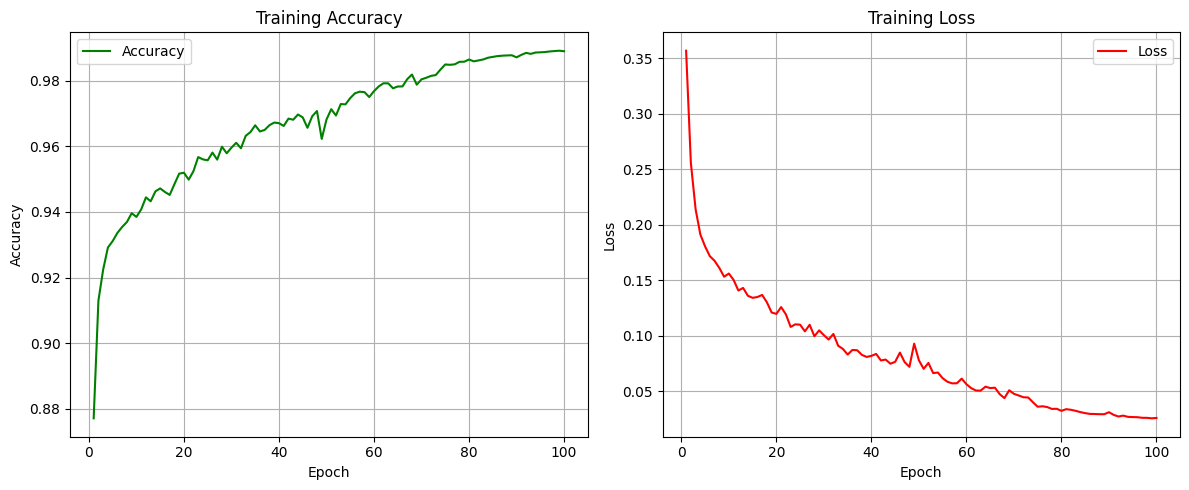

In [14]:
# Trích xuất dữ liệu từ lịch sử huấn luyện
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(acc) + 1)

# Vẽ biểu đồ Accuracy và Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Accuracy', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()

# Lưu hình ảnh vào file PNG
plt.savefig('resunet_2750.png', dpi=300)

# Hiển thị biểu đồ
plt.show()


In [15]:
# Hàm hậu xử lý bằng Morphological Operations
def apply_morphology(mask, kernel_size=3, iterations=1):
    """
    Morphological post-processing: closing -> opening để loại bỏ nhiễu và lỗ hổng.
    - kernel_size: Kích thước kernel (thường 3, 5, 7).
    - iterations: Số lần áp dụng phép toán (1-2 là đủ).
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = (mask > 0.5).astype(np.uint8)  # Ngưỡng hóa trước

    # Closing để lấp lỗ hổng nhỏ
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    # Opening để loại bỏ nhiễu
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=iterations)

    return opened.astype(np.float32)  # Chuyển về float để tính toán metrics

# Đánh giá mô hình gốc (không hậu xử lý)
print("🔍 Đánh giá không hậu xử lý...")
results = resunet.evaluate(test_images_gray_clahe, test_masks, verbose=1)
loss, accuracy, jaccard = results
print(f"Không hậu xử lý - Dice Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%, Jaccard: {jaccard*100:.2f}%")

# Dự đoán và hậu xử lý chỉ với Morphological Operations
print("\n🔧 Đánh giá sau Morphology...")
predictions1 = resunet.predict(test_images_gray_clahe)
refined_predictions1 = []

for i in tqdm(range(len(test_images_gray_clahe))):
    pred = predictions1[i].squeeze()  # Loại bỏ chiều batch nếu cần

    # Áp dụng Morphological Operations
    morph_pred = apply_morphology(pred, kernel_size=7, iterations=2)  # Thử kernel_size=5

    refined_predictions1.append(morph_pred)

    # Lưu ảnh mẫu để so sánh
    # if i < 3:
    #     cv2.imwrite(f'before_morph_{i}.png', (pred > 0.5).astype(np.uint8) * 255)
    #     cv2.imwrite(f'after_morph_{i}.png', morph_pred * 255)

# Chuyển sang numpy array và thêm chiều channel nếu cần
refined_predictions1 = np.expand_dims(np.array(refined_predictions1), axis=-1)

# Tính toán metrics
accuracy_after = np_accuracy(test_masks, refined_predictions1)
jaccard_after = np_jaccard_coefficient(test_masks, refined_predictions1)
loss_after = np_dice_loss(test_masks, refined_predictions1)

print(f"Sau Morphology - Dice Loss: {loss_after:.4f}, Accuracy: {accuracy_after*100:.2f}%, Jaccard: {jaccard_after*100:.2f}%")

🔍 Đánh giá không hậu xử lý...


W0000 00:00:1751345779.585749     214 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1751345779.585914     214 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9476 - jaccard_coefficient: 0.7790 - loss: 0.1269

W0000 00:00:1751345788.524114     214 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1751345788.524243     214 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 967ms/step - accuracy: 0.9473 - jaccard_coefficient: 0.7745 - loss: 0.1299
Không hậu xử lý - Dice Loss: 0.1675, Accuracy: 94.24%, Jaccard: 71.85%

🔧 Đánh giá sau Morphology...
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step

W0000 00:00:1751345823.167119     215 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1751345823.167232     215 assert_op.cc:38] Ignoring Assert operator ResUNet_1/gray_to_rgb_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 490ms/step


100%|██████████| 825/825 [00:00<00:00, 1348.93it/s]


Sau Morphology - Dice Loss: 0.1492, Accuracy: 94.24%, Jaccard: 74.03%


In [16]:
def show_predictions_with_metrics_grid(refined_predictions1,
                                       images, masks,
                                       indices,
                                       save_path):

    num_images = len(indices)
    plt.figure(figsize=(8, 4 * num_images))  # 2 cột, num_images hàng

    for i, idx in enumerate(indices):
        image = images[idx]
        true_mask = masks[idx]
        pred_morph = refined_predictions1[idx]

        # Resize pred_morph về cùng kích thước với true_mask nếu cần
        if pred_morph.shape != true_mask.shape:
            pred_morph = cv2.resize(pred_morph, (true_mask.shape[1], true_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Tính metrics
        accuracy = np_accuracy(true_mask, pred_morph)

        # Cột 1: Ảnh gốc
        ax1 = plt.subplot(num_images, 2, 2*i + 1)
        ax1.imshow(image)
        # ax1.set_title(f"Ảnh gốc - idx {idx}", fontsize=14)
        ax1.axis('off')

        # Cột 2: Ảnh morphology + metrics
        ax2 = plt.subplot(num_images, 2, 2*i + 2)
        ax2.imshow(pred_morph, cmap='gray')
        # ax2.set_title("Hậu xử lý Morphology", fontsize=14)
        ax2.axis('off')
        ax2.text(0.5, -0.01,
                 f"Accuracy: {accuracy:.3f}",
                 fontsize=10, ha='center', va='top', transform=ax2.transAxes)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

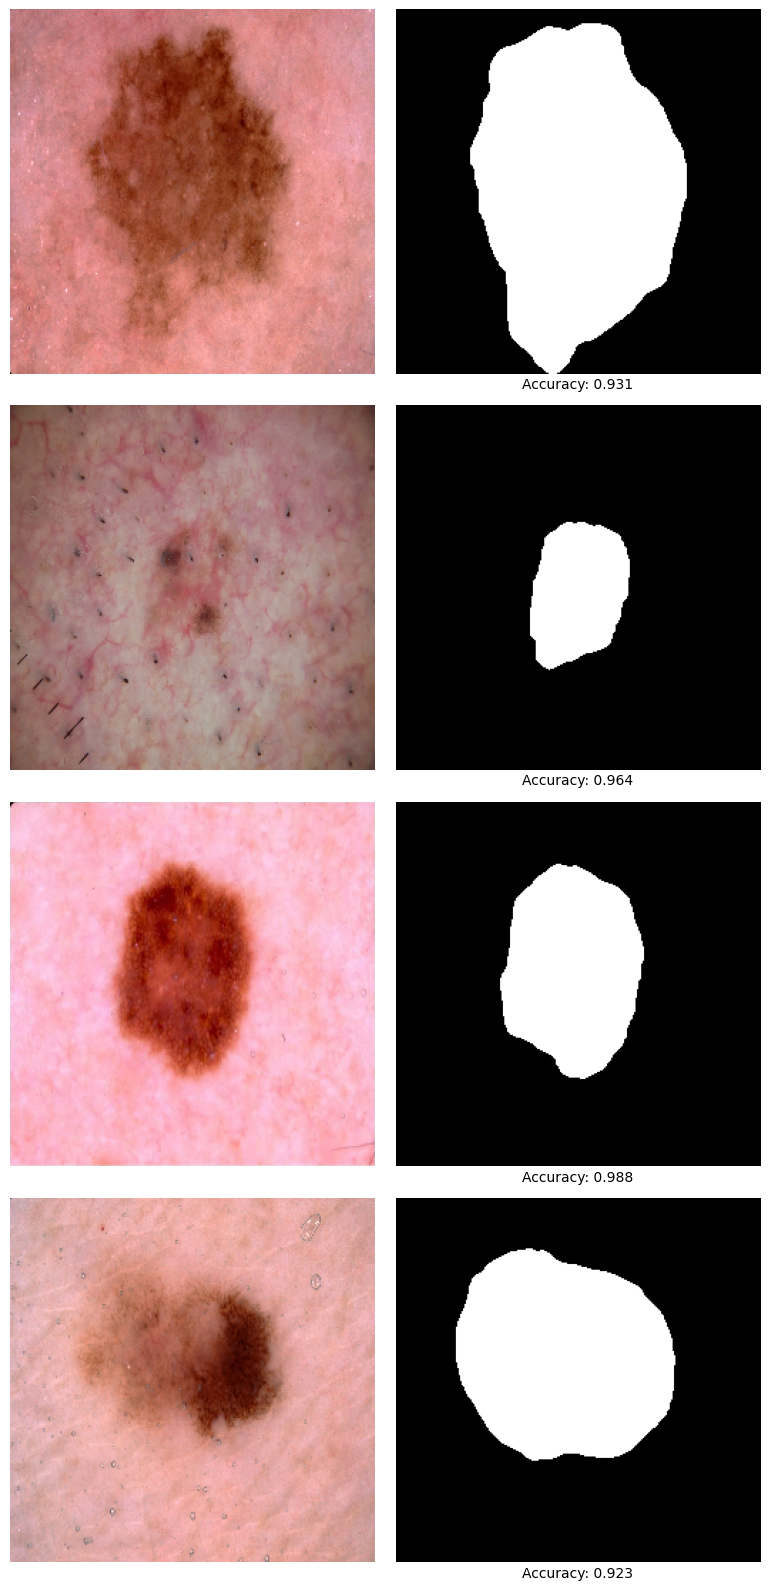

In [85]:
show_predictions_with_metrics_grid(
    refined_predictions1=refined_predictions1,
    images=test_images,
    masks=test_masks,
    indices=[722, 191, 54, 700],
    save_path="/kaggle/working/resunet_2750.png"
)

In [29]:
resunet.save('/kaggle/working/model/resunet_2750_model.h5')
resunet.save('/kaggle/working/model/resunet_2750_model.keras')